In [1]:
# this is our preamble cell :
import plotly.graph_objects as go
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

from sklearn import cluster
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

# from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [15]:
# importing and minor cleaning first, parsing dates. 

dfreal = pd.read_csv('True.csv',
                    parse_dates = ['date'])
#                    index_col = 'date')
dfreal['Fake'] = 0
print('Real data shape: ', dfreal.shape)

dffake = pd.read_csv('Fake.csv',
                    parse_dates = ['date'])
#                    index_col = 'date')

dffake['Fake'] = 1

# I have added the boolean column for Fake/Real to each. 

# This next bit will clean up the messy date columns from the fake csv. 

searchfor = ['http', '-', 'MSNBC']
dffake = dffake[~dffake['date'].str.contains('|'.join(searchfor))]

print('Fake data shape: ', dffake.shape)


Real data shape:  (21417, 5)
Fake data shape:  (23436, 5)


In [16]:
# Now, I want to trim them to be the same size, so that we have our baseline right at 0.5 -the same as flipping a coin. 

dfreal_trimmed = dfreal[-21_400 :]
print('Real trimmed shape: ', dfreal_trimmed.shape)

dffake_trimmed = dffake[-21_400 :]
print('Fake trimmed shape: ', dffake_trimmed.shape)

# and now combine them into one dataframe:
df_joined = dfreal_trimmed.append(dffake_trimmed, ignore_index=True)

df_joined['date'] = pd.to_datetime(df_joined['date'])

print()
print('Combined and trimmed (equal parts Real and Fake) shape: ', df_joined.shape)
print()
print(df_joined.info())

Real trimmed shape:  (21400, 5)
Fake trimmed shape:  (21400, 5)

Combined and trimmed (equal parts Real and Fake) shape:  (42800, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42800 entries, 0 to 42799
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    42800 non-null  object        
 1   text     42800 non-null  object        
 2   subject  42800 non-null  object        
 3   date     42800 non-null  datetime64[ns]
 4   Fake     42800 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.6+ MB
None


In [23]:
df_joined.head(2)


,title,text,subject,date,Fake
0,"Trump on Twitter (Dec 26) - Hillary Clinton, T...",The following statements were posted to the ve...,politicsNews,2017-12-26,0
1,U.S. appeals court rejects challenge to Trump ...,(Reuters) - A U.S. appeals court in Washington...,politicsNews,2017-12-26,0


In [24]:
df_joined.tail(2)

,title,text,subject,date,Fake
42798,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,1
42799,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,2016-01-12,1


In [25]:
# we're going to need to drop those colums that will interfere with the model once we have vectorized the text. 
# for now, we will drop subject and leave date. 


# This kaggle data does not have evenly distributed subjects. 
# While it is technically a predictor in this case, it is hardly objective. 
# Therefore, I am dropping subject .
df_joined.drop(['subject'], axis=1, inplace=True)


# I'm also making the choice to drop 'Date' as well. 
# Similarly, the dates are not well distributed, and will throw off the purity of the model. 
df_joined.drop(['date'], axis=1, inplace=True)

# Since later I will want to run the vectorizer on article title, separate the title column into another frame... 

df_joined_titles = df_joined.drop(['text'], axis=1)

# and likewise, since these nlp vectorizers can only process one column at a time (took me way too long to grok that),
# I will drop my title column from the dataframe with the main bodies (corpi? corpuses?) of articles.

df_joined = df_joined.drop(['title'], axis=1)

print('df_joined, with main body: ',df_joined.columns)
print('df_joined_titles, with titles :',df_joined_titles.columns)

df_joined, with main body:  Index(['text', 'Fake'], dtype='object')
df_joined_titles, with titles : Index(['title', 'Fake'], dtype='object')


In [26]:
df_joined.head(2)

,text,Fake
0,The following statements were posted to the ve...,0
1,(Reuters) - A U.S. appeals court in Washington...,0


In [27]:
df_joined.tail(2)

,text,Fake
42798,21st Century Wire says Al Jazeera America will...,1
42799,21st Century Wire says As 21WIRE predicted in ...,1


## OK, now that everything is very trimmed up we can move into setting up for pipeline. I'm leaving a count vectorizer below in case we need it later. 



In [5]:
## Count Vectorizer in case we need it later
## THIS IS JUST DONE TO THE TEXT COLUMN, but we can copy the CountVect params later if we need it. 
# instantiate the count vectorizer:
cv = CountVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, max_df = 0.95 , min_df = 0.01 )

# here's a function to return a dataframe:

def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())

# now here's the actual "thing":

df_joined_CountVector = create_term_matrix(df_joined['text'], cv)

df_joined_CountVector.shape

(42800, 50)

## Feature / Target Split



In [6]:
# This is the feature / target split for our main article text. 

target_body = df_joined['Fake']

Xb = df_joined['text']

yb = target_body

print('Xb (body) shape: ', Xb.shape)
print('yb (body) shape: ', yb.shape)

Xb (body) shape:  (42800,)
yb (body) shape:  (42800,)


In [7]:
# This is the feature / target split for our article title text. 

target_title = df_joined_titles['Fake']

Xt = df_joined_titles['title']

yt = target_title

print('Xt (title) shape: ', Xt.shape)
print('yt (title) shape: ', yt.shape)

Xt (title) shape:  (42800,)
yt (title) shape:  (42800,)


## now we can do our training, validation and test split for both dataframes. 

In [8]:
# Train test split, then apply the same function again to get a validation set. 

#This cell is for out 'body' set. 

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)

# doing 20/80 split and 42. and then the same to split val set from train set.

Xb_train, Xb_val, yb_train, yb_val = train_test_split(Xb_train, yb_train, test_size=0.2, random_state=42) 


print(Xb_train.shape)
print(yb_train.shape)
print(Xb_val.shape)
print(yb_val.shape)
print(Xb_test.shape)
print(yb_test.shape)

(27392,)
(27392,)
(6848,)
(6848,)
(8560,)
(8560,)


In [9]:
# Train test split, then apply the same function again to get a validation set. 

#This cell is for out 'title' set. 

Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)

# doing 20/80 split and 42. and then the same to split val set from train set.

Xt_train, Xt_val, yt_train, yt_val = train_test_split(Xt_train, yt_train, test_size=0.2, random_state=42) 


print(Xt_train.shape)
print(yt_train.shape)
print(Xt_val.shape)
print(yt_val.shape)
print(Xt_test.shape)
print(yt_test.shape)

(27392,)
(27392,)
(6848,)
(6848,)
(8560,)
(8560,)


In [11]:
print(Xb_train.head)


<bound method NDFrame.head of 27029    He s not wrong.Demonstrating that he is the on...
41417    21st Century Wire says Those on the  left  nee...
19390    BEIJING (Reuters) - Beijing s city authorities...
20653    (Reuters) - Airlines were racing against the c...
21793    Joni Ernst may portray herself as tough in her...
                               ...                        
26807    At this point in the election, Republican fron...
33175    Bill s gonna wish his corrupt wife never ran f...
5032     WASHINGTON (Reuters) - Three U.S. senators ask...
25802    Stand your ground laws are reasons for legaliz...
35473    MARK STEYN ON TRUMP S MOVE LAST NIGHT:   @Mark...
Name: text, Length: 27392, dtype: object>


# Model Section

## for now, I am going to run all my models with the article body 'text' column...
## later I will move into the title models... 

## Model_Test with Ngram range (1,2)

In [12]:
# TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, min_df= 0.25 , max_df= 0.75)

model_test = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model_test.fit(Xb_train, yb_train); 

print(model_test.score(Xb_train, yb_train))

      Iter       Train Loss   Remaining Time 
         1           1.2016            5.15s
         2           1.0504            5.10s
         3           0.9244            5.08s
         4           0.8180            5.00s
         5           0.7272            4.96s
         6           0.6491            4.90s
         7           0.5815            4.85s
         8           0.5226            4.81s
         9           0.4712            4.76s
        10           0.4259            4.71s
        20           0.1793            4.15s
        30           0.1001            3.63s
        40           0.0732            3.11s
        50           0.0595            2.59s
        60           0.0510            2.07s
        70           0.0439            1.55s
        80           0.0405            1.03s
        90           0.0371            0.52s
       100           0.0331            0.00s
0.9953271028037384


## MODEL 1 :  min 0.25  |  max 0.75

In [93]:
model1 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, min_df= 0.25 , max_df= 0.75)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model1.fit(Xb_train, yb_train); 

print('model1 train: ', model1.score(Xb_train, yb_train))
print('model1 val: ', model1.score(Xb_val, yb_val))
print('model1 test: ',model1.score(Xb_test, yb_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.2016            5.64s
         2           1.0503            5.63s
         3           0.9244            5.55s
         4           0.8179            5.49s
         5           0.7272            5.46s
         6           0.6492            5.38s
         7           0.5815            5.33s
         8           0.5227            5.29s
         9           0.4710            5.22s
        10           0.4258            5.17s
        20           0.1795            4.55s
        30           0.0997            4.00s
        40           0.0718            3.43s
        50           0.0591            2.86s
        60           0.0535            2.28s
        70           0.0489            1.71s
        80           0.0443            1.14s
        90           0.0413            0.57s
       100           0.0374            0.00s
model1 train:  0.9951445677570093
model1 val:  0.9919684579439252
model1 test:  0.994392523364486



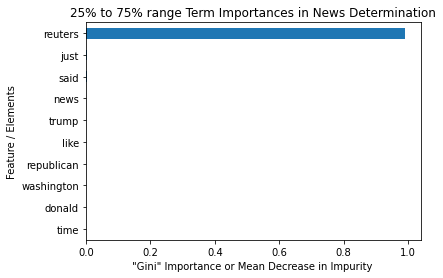

In [122]:
# lets see what's going on here... 

vectorizer = TfidfVectorizer()
importances = model1.named_steps['predictor'].feature_importances_
features = model1.named_steps['vectorizer'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('25% to 75% range Term Importances in News Determination');

# REUTERS

## Obviously, Reuters is a trusted news source. 

this begs the question, what would our model think if we were comparing a grouping of articles that did not include any sourced from Reuters?

## MODEL 2 - min: 0.25   |  max: 0.5

In [29]:
# tfidf02 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.25 , max_df= 0.5)

model2 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.25 , max_df= 0.5)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

model2.fit(Xb_train, yb_train);
print('model2 train: ', model2.score(Xb_train, yb_train))
print('model2 val: ', model2.score(Xb_val, yb_val))
print('model2 test: ',model2.score(Xb_test, yb_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3356            4.48s
         2           1.2936            4.41s
         3           1.2590            4.33s
         4           1.2285            4.30s
         5           1.2005            4.27s
         6           1.1772            4.23s
         7           1.1563            4.17s
         8           1.1375            4.13s
         9           1.1198            4.08s
        10           1.1047            4.03s
        20           0.9966            3.59s
        30           0.9338            3.14s
        40           0.8988            2.69s
        50           0.8714            2.24s
        60           0.8497            1.79s
        70           0.8335            1.34s
        80           0.8201            0.89s
        90           0.8092            0.45s
       100           0.8001            0.00s
model2 train:  0.8223568925233645
model2 val:  0.814982476635514
model2 test:  0.8217289719626168



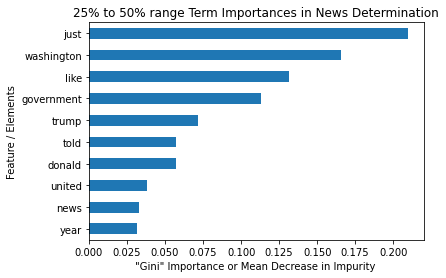

In [121]:
# model 2 feature importances graph

vectorizer = TfidfVectorizer()
importances = model2.named_steps['predictor'].feature_importances_
features = model2.named_steps['vectorizer'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('25% to 50% range Term Importances in News Determination');

## Model 03 : min 0.05  |  max 0.5

In [30]:
# Third Model

model3 = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.05 , max_df= 0.5)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

model3.fit(Xb_train, yb_train);
print('model3 train: ', model3.score(Xb_train, yb_train))
print('model3 val: ', model3.score(Xb_val, yb_val))
print('model3 test: ',model3.score(Xb_test, yb_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3256           16.05s
         2           1.2707           16.07s
         3           1.2264           16.03s
         4           1.1865           15.81s
         5           1.1491           15.64s
         6           1.1178           15.64s
         7           1.0896           15.49s
         8           1.0607           15.29s
         9           1.0371           15.17s
        10           1.0141           15.05s
        20           0.8318           13.54s
        30           0.7200           11.77s
        40           0.6437           10.02s
        50           0.5890            8.31s
        60           0.5461            6.64s
        70           0.5137            4.97s
        80           0.4864            3.31s
        90           0.4630            1.65s
       100           0.4430            0.00s
model3 train:  0.9325350467289719
model3 val:  0.9192464953271028
model3 test:  0.9184579439252336


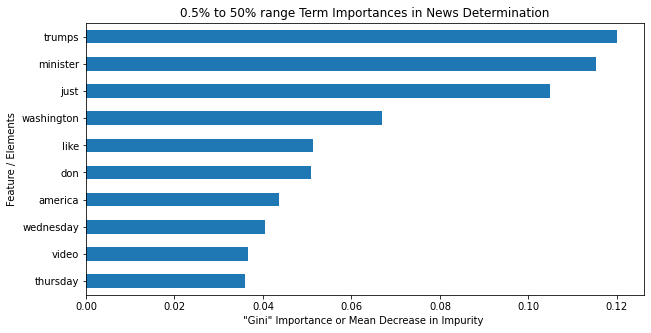

In [33]:
# model 3 feature importances graph

vectorizer = TfidfVectorizer()
importances = model3.named_steps['predictor'].feature_importances_
features = model3.named_steps['vectorizer'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh', figsize=(10,5))
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('0.5% to 50% range Term Importances in News Determination');

## Model 04 -  min 0.01  |  max 0.1

In [35]:

## Model 04 -  min 0.01  |  max 0.1
model4 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.01 , max_df= 0.1)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])


model4.fit(Xb_train, yb_train);
print('model4 train: ', model4.score(Xb_train, yb_train))
print('model4 val: ', model4.score(Xb_val, yb_val))
print('model4 test: ',model4.score(Xb_test, yb_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3466            9.45s
         2           1.3143            9.96s
         3           1.2873           10.31s
         4           1.2636           10.29s
         5           1.2431           10.30s
         6           1.2238           10.23s
         7           1.2070           10.13s
         8           1.1915           10.02s
         9           1.1772            9.86s
        10           1.1630            9.72s
        20           1.0595            8.49s
        30           0.9892            7.35s
        40           0.9380            6.16s
        50           0.8973            5.06s
        60           0.8650            4.02s
        70           0.8380            2.99s
        80           0.8153            1.98s
        90           0.7955            0.99s
       100           0.7780            0.00s
model4 train:  0.851197429906542
model4 val:  0.8478387850467289
model4 test:  0.8353971962616823



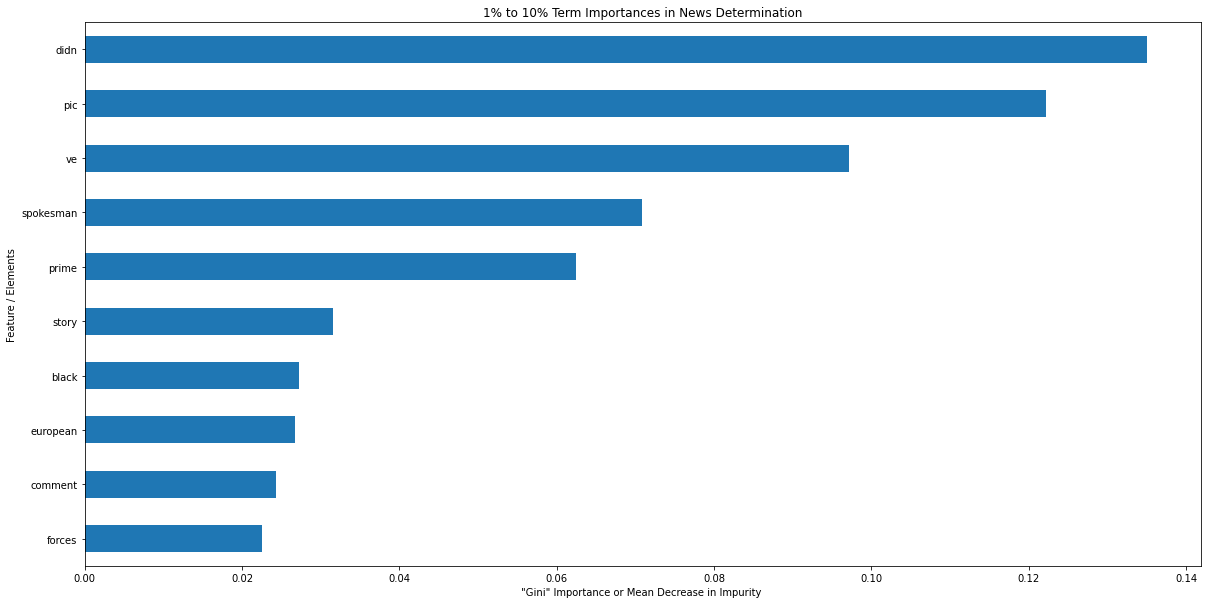

In [36]:
# model 4 feature importances graph

vectorizer = TfidfVectorizer()
importances = model4.named_steps['predictor'].feature_importances_
features = model4.named_steps['vectorizer'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh', figsize = (20,10))
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('1% to 10% Term Importances in News Determination');

# Plenty of results to sort through in the 4 models above... 

## Now, I would like to investigate the same procedure but for titles instead. 

I suspect I will need to lower my max features in some cases, let's see. 
After this we will do some GridSearchCV instead of GradientBoostingClassifier

In [103]:
# Alright, a test model with article titles. 

model_test2 = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model_test2.fit(Xt_train, yt_train); 

print('model_test2 train: ', model_test2.score(Xt_train, yt_train))
print('model_test2 val: ', model_test2.score(Xt_val, yt_val))
print('model_test2 test: ',model_test2.score(Xt_test, yt_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3294            1.09s
         2           1.2827            1.13s
         3           1.2433            1.13s
         4           1.2092            1.13s
         5           1.1800            1.12s
         6           1.1544            1.11s
         7           1.1319            1.09s
         8           1.1120            1.08s
         9           1.0947            1.06s
        10           1.0789            1.04s
        20           0.9874            0.89s
        30           0.9468            0.78s
        40           0.9215            0.67s
        50           0.9044            0.55s
        60           0.8941            0.44s
        70           0.8853            0.33s
        80           0.8794            0.22s
        90           0.8750            0.11s
       100           0.8710            0.00s
model_test2 train:  0.7770882009345794
model_test2 val:  0.7711740654205608
model_test2 test:  0.77

## TITLE MODEL 1 :  min 0.25  |  max 0.75

In [116]:
title_model1 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, min_df= 0.25 , max_df= 0.75)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
title_model1.fit(Xt_train, yt_train); 
print('title_model1 train: ', title_model1.score(Xt_train, yt_train))
print('title_model1 val: ', title_model1.score(Xt_val, yt_val))
print('title_model1 test: ',title_model1.score(Xt_test, yt_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3859            0.30s
         2           1.3856            0.29s
         3           1.3853            0.29s
         4           1.3851            0.26s
         5           1.3849            0.27s
         6           1.3848            0.27s
         7           1.3847            0.25s
         8           1.3846            0.25s
         9           1.3845            0.25s
        10           1.3844            0.25s
        20           1.3842            0.20s
        30           1.3842            0.17s
        40           1.3842            0.15s
        50           1.3842            0.12s
        60           1.3842            0.10s
        70           1.3842            0.07s
        80           1.3842            0.05s
        90           1.3842            0.02s
       100           1.3842            0.00s
title_model1 train:  0.520772488317757
title_model1 val:  0.5173773364485982
title_model1 test:  0.

## not even gonna graph it, barely beats baseline, which was as low as possible to begin with... 

## TITLE MODEL 2 - min: 0.25   |  max: 0.5

In [115]:
title_model2 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.25 , max_df= 0.5)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

title_model2.fit(Xt_train, yt_train); 
print('title_model2 train: ', title_model2.score(Xt_train, yt_train))
print('title_model2 val: ', title_model2.score(Xt_val, yt_val))
print('title_model2 test: ',title_model2.score(Xt_test, yt_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3859            0.30s
         2           1.3856            0.29s
         3           1.3853            0.29s
         4           1.3851            0.29s
         5           1.3849            0.28s
         6           1.3848            0.27s
         7           1.3847            0.26s
         8           1.3846            0.26s
         9           1.3845            0.26s
        10           1.3844            0.26s
        20           1.3842            0.21s
        30           1.3842            0.18s
        40           1.3842            0.15s
        50           1.3842            0.12s
        60           1.3842            0.10s
        70           1.3842            0.07s
        80           1.3842            0.05s
        90           1.3842            0.02s
       100           1.3842            0.00s
title_model2 train:  0.520772488317757
title_model2 val:  0.5173773364485982
title_model2 test:  0.

## TITLE MODEL 03 : min 0.05  |  max 0.5

In [110]:
title_model3 = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.05 , max_df= 0.5)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])


title_model3.fit(Xt_train, yt_train); 
print('title_model3 train: ', title_model3.score(Xt_train, yt_train))
print('title_model3 val: ', title_model3.score(Xt_val, yt_val))
print('title_model3 test: ', title_model3.score(Xt_test, yt_test))
print()

      Iter       Train Loss   Remaining Time 
         1           1.3354            0.50s
         2           1.2938            0.44s
         3           1.2593            0.45s
         4           1.2304            0.46s
         5           1.2059            0.44s
         6           1.1850            0.44s
         7           1.1671            0.44s
         8           1.1517            0.44s
         9           1.1383            0.42s
        10           1.1267            0.42s
        20           1.0664            0.36s
        30           1.0486            0.31s
        40           1.0432            0.26s
        50           1.0417            0.22s
        60           1.0414            0.18s
        70           1.0413            0.13s
        80           1.0412            0.09s
        90           1.0412            0.04s
       100           1.0412            0.00s
title_model3 train:  0.6994012850467289
title_model3 val:  0.6875
title_model3 test:  0.70058411214

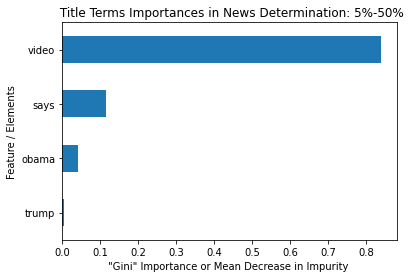

In [127]:
# That's a jump up - let's graph it just out of curiosity. 

vectorizer = TfidfVectorizer()
importances = title_model3.named_steps['predictor'].feature_importances_
features = title_model3.named_steps['vectorizer'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title(' Title Terms Importances in News Determination: 5%-50%');

In [108]:
# VIDEO SAYS OBAMA TRUMP. 
# Not really that funny, but it got a high score which is fascinating. 
# Moving onwards...


## TITLE MODEL 04 -  min 0.01  |  max 0.1

In [111]:

title_model4 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.01 , max_df= 0.1)),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

title_model4.fit(Xt_train, yt_train);
print('title_model4 train: ', title_model4.score(Xt_train, yt_train))
print('title_model4 val: ', title_model4.score(Xt_val, yt_val))
print('title_model4 test: ', title_model4.score(Xt_test, yt_test))
print()


      Iter       Train Loss   Remaining Time 
         1           1.3624            3.93s
         2           1.3429            3.85s
         3           1.3267            3.77s
         4           1.3125            3.73s
         5           1.2992            3.69s
         6           1.2877            3.69s
         7           1.2771            3.65s
         8           1.2679            3.61s
         9           1.2587            3.57s
        10           1.2505            3.53s
        20           1.1829            3.27s
        30           1.1351            3.02s
        40           1.0986            2.60s
        50           1.0673            2.15s
        60           1.0423            1.73s
        70           1.0212            1.29s
        80           1.0027            0.87s
        90           0.9864            0.43s
       100           0.9732            0.00s
title_model4 train:  0.7647123247663551
title_model4 val:  0.7479556074766355
title_model4 test:  0

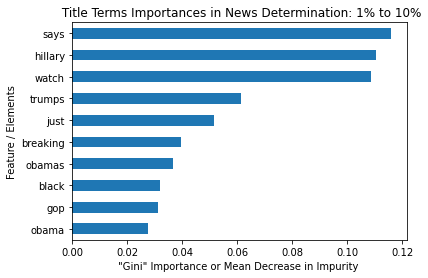

In [128]:
#OK, fun, similarly, a high score. Let's graph this thing! 

vectorizer = TfidfVectorizer()
importances = title_model4.named_steps['predictor'].feature_importances_
features = title_model4.named_steps['vectorizer'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title(' Title Terms Importances in News Determination: 1% to 10%');


## Below is Josh Carlisle's first pass. It's important to acknowledge a few things. 
## Josh showed me how I could "clean it all up" quite a bit, for which I am grateful. 
## We all need a helping hand sometimes, and if you stop learning or crituquing yourself then you cease to grow. 
## I realize now after going through my own modeling process though, that Josh's code feel victim to the "Reuters" predictor that I identified earlier. 
## Josh's Github : https://github.com/Jroc561

In [ ]:
# # Josh Carslisle's Take on it all...

## TL;DR - running GridSearchCV on the entire corpus (corpi?) doesn't eliminate the Reuters issue. 

## getting the range from model03 is in my opinion more realistic - 
## doc-frequency in the less common ranges is a better predictor objectively. 


# https://github.com/Jroc561
# import xgboost as xgb
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

# # Lets simplify : df_joined DF (80/20) split

# train = df_joined.loc[:34240,:]
# test = df_joined.loc[8560:,:]

# # For testing 

# y = train['Fake']
# X = train['text']

# # Instantiate vectorizer object
# vect = TfidfVectorizer(stop_words='english')
# clf = xgb.XGBClassifier() #estimator
# clf2 = GradientBoostingClassifier(random_state=42)

# # Define the Pipeline
# pipe = Pipeline([('vect', vect), ('clf', clf)])

# # super basic parameter list for tuning
# parameters = {
#     'vect__max_features': [500, 1000],
#     'clf__n_estimators':[75, 125]}
# # create the gridsearch
# grid_search = GridSearchCV(pipe, parameters, cv= 3, n_jobs=4, scoring='accuracy', verbose=1)
# grid_search.fit(X, y) # fit the model

# # results
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# # lets see how it does agaisnt the test
# pred = grid_search.predict(test['text'])

## Let's try for some more graphing... 

In [46]:
# import chart_studio.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# from wordcloud import WordCloud

# x2011 = title_model3.named_steps['predictor'].feature_importances_

# plt.subplots(figsize = (8,8))

# wordcloud = WordCloud (
#                     background_color = 'white',
#                     width = 512,
#                     height = 384
#                         ).generate(' '.join(x2011))
# plt.imshow(wordcloud) # image show
# plt.axis('off') # to off the axis of x and y
# plt.savefig('Plotly-World_Cloud.png')
# plt.show()